<div style="text-align: center; font-size: 35px;">
Rental Prices in Israel, August 2023 - EDA
</div>

# Introduction

This is a research project I conducted for fun while searching for an apartment to rent. The data corrsponds the month of August 2023 and includes rental prices for six different cities in Israel. The cities are ordered by their proximity to Tel Aviv, from closest to farthest: Tel Aviv, Holon, Bat Yam, Rishon LeZion, Rehovot, and Ashkelon.

Each city dataset is formed by the following columns:

* **ILS**: The rental cost of the property in NIS (New Israel Shekels).
* **floor**: The floor level of the property.
* **rooms**: The number of rooms of the property (some feature engineering might be required here).
* **type**: The type of property (e.g., penthouse, apartment, etc.).
* **surface**: The surface of the property in square meters.

This study is focused mainly on the property rental price based on surface. Then we continue the analysis moving to different ML models testing, and establish the three best models.

**Disclaimer 1**: Please note that I have no field-specific expertise, and this analysis is purely exploratory.

**Disclaimer 2**: Note this dataset is superficial, its variables don't include some [relevant data](https://www.placer.ai/guides/real-estate-data-analytics) like center-wide visitation trends, foot traffic analytics for specific venues, demographic insights, cross-shopping data, frequent co-tenancy, an in-depth analysis of potential competition.

# Study Justification:

Tel Aviv held the title of [the most expensive city in the world](https://www.bbc.co.uk/news/world-middle-east-59489259) for a brief period. In 2021, [it overtook Paris](https://www.economistgroup.com/group-news/economist-intelligence/tel-aviv-overtakes-paris-to-become-the-worlds-most-expensive-city) to become the world's most expensive city according to the Economist Intelligence Unit (EIU) World Cost of Living rankings. However, in subsequent years, Tel Aviv lost its top position. In 2022, [it ranked third, and by 2023, it was eighth](https://www.timesofisrael.com/tel-aviv-ranked-eighth-most-expensive-city-in-the-world-for-foreigners/). The soaring value of Israel's currency, the shekel, and significant price increases for goods contributed to Tel Aviv's high cost of living.

In this study we will take a rental price overview comparison among the cities, and focusing in Tel Aviv.

# 1. Data Exploration

We start by exploring our dataset, but first we import the necessary libraries:

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
import math

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

# For statistic metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler

# For saving models
import pickle

We import our data:

In [2]:
df_ashkelon = pd.read_csv('df_ashkelon.csv')
df_batiam = pd.read_csv('df_batiam.csv')
df_holon = pd.read_csv('df_holon.csv')
df_rehovot = pd.read_csv('df_rehovot.csv')
df_rishon = pd.read_csv('df_rishon.csv')
df_telaviv = pd.read_csv('df_telaviv.csv')

## Data Cleaning

Most of the cleaning was already made, but stil remain some NaN Values

We check the data structure and how many NaN do we have:

In [3]:
# dataframes estructure
df_ashkelon.head()

,rooms,floor,surface m2,ILS,type
0,2.0,1,60.0,2200,apartment
1,4.0,5,120.0,3700,apartment
2,3.0,5,90.0,3500,apartment
3,5.0,10,139.0,5000,apartment
4,4.0,2,95.0,3000,apartment


We check dataframes and NaN values

In [4]:
# dataframes of the cities
cities = ["Ashkelon", "Bat Yam", "Holon", "Rehovot", "Rishon LeZion", "Tel Aviv"]
data_frames = [df_ashkelon, df_batiam, df_holon, df_rehovot, df_rishon, df_telaviv]

for city, df in zip(cities, data_frames):
    # Count the number of NaN values in each column
    nan_counts = df.isna().sum()
    print(f"NaN counts in {city}:")
    print(nan_counts)
    print()  # Add an empty line for readability

NaN counts in Ashkelon:
rooms         0
floor         0
surface m2    1
ILS           0
type          0
dtype: int64

NaN counts in Bat Yam:
rooms         0
floor         0
surface m2    0
ILS           0
type          0
dtype: int64

NaN counts in Holon:
rooms         0
floor         0
surface m2    0
ILS           0
type          0
dtype: int64

NaN counts in Rehovot:
rooms         0
floor         0
surface m2    0
ILS           0
type          0
dtype: int64

NaN counts in Rishon LeZion:
rooms         2
floor         0
surface m2    0
ILS           0
type          0
dtype: int64

NaN counts in Tel Aviv:
rooms         0
floor         0
surface m2    0
ILS           0
type          0
dtype: int64



We see above there are not many, so we eliminate those rows:

In [5]:
# for the individual fataframes:
# create new dataframes without NaN values
cleaned_data = []

for city, df in zip(cities, data_frames):
    # Remove rows with NaN values
    cleaned_df = df.dropna()
    cleaned_data.append(cleaned_df)

# upadte data_frames with cleaned_data
data_frames = cleaned_data

In [6]:
# We check how many data we have for each dataframe    
for city, df in zip(cities, data_frames):
    rows_number = len(df)
    print(f"{city} has {rows_number} rows")

Ashkelon has 721 rows
Bat Yam has 725 rows
Holon has 720 rows
Rehovot has 529 rows
Rishon LeZion has 719 rows
Tel Aviv has 740 rows


As seen above, the data size for each city is a little more than 700 except for Bat Yam. This can pose challenges when attempting to build a deep learning (DL) model. However, in this EDA, if we discover two or more cities with similar trends, we could consider grouping them for modeling purposes. Additionally all cities have very similar row quantity except for Bat Yam, we might take note of that in the future when modeling.

Now we'll also remove all half rooms from the dataframes and make a new list with that. That is if 'rooms' = 1.5, then we'll have 'rooms'=1, then we add a new row called 'extra_space' for when 'rooms' is a semi integer.

In [7]:
for i in range(len(data_frames)):
    
    # select the dataframe
    df = data_frames[i].copy()
    
    # we create the 'extra_space' column
    extra_space = ~np.isclose(df['rooms'], np.round(df['rooms']), 0)
    df.loc[:, 'extra_space'] = extra_space.astype(int)
    # we round down 'rooms'
    df['rooms'] = np.floor(df['rooms']).astype(int) # this DOES work
    # df.loc[:, 'rooms'] = (df['rooms']).astype(int) # this doesnt work

    # replace the dataframe in the list
    data_frames[i] = df

data_frames[1].head()

,rooms,floor,surface m2,ILS,type,extra_space
0,2,18,50,6000,apartment,0
1,2,3,56,3700,apartment,0
2,5,24,147,8700,apartment,0
3,3,1,80,5600,apartment,0
4,4,2,82,5000,apartment,0


We caan see above we only have some very basic information, and lack certain relevant data points such as parking availability, the number of bathrooms, or whether it's an office space. These data (and even less) can be enough for a basic ML model.

Now we check the basic stats:

In [8]:
for i in range(len(data_frames)):
    print(f'{cities[i]} info:')
    print(data_frames[i].info())
    print()

Ashkelon info:
<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 721
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rooms        721 non-null    int64  
 1   floor        721 non-null    int64  
 2   surface m2   721 non-null    float64
 3   ILS          721 non-null    int64  
 4   type         721 non-null    object 
 5   extra_space  721 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 39.4+ KB
None

Bat Yam info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rooms        725 non-null    int64 
 1   floor        725 non-null    int64 
 2   surface m2   725 non-null    int64 
 3   ILS          725 non-null    int64 
 4   type         725 non-null    object
 5   extra_space  725 non-null    int64 
dtypes: int64(5), object(1)
memory 

In [9]:
for i in range(len(data_frames)):
    print(f'{cities[i]} stats:')
    print(data_frames[i].describe())
    print()

Ashkelon stats:
            rooms      floor  surface m2           ILS  extra_space
count  721.000000  721.00000  721.000000    721.000000   721.000000
mean     3.567268    3.81276  106.081831   3937.423024     0.084605
std      1.156496    3.48563   55.872128   1501.045976     0.278486
min      1.000000   -1.00000    1.000000    100.000000     0.000000
25%      3.000000    1.00000   74.000000   3100.000000     0.000000
50%      4.000000    3.00000  100.000000   3800.000000     0.000000
75%      4.000000    5.00000  126.000000   4500.000000     0.000000
max      7.000000   24.00000  500.000000  20000.000000     1.000000

Bat Yam stats:
            rooms       floor   surface m2           ILS  extra_space
count  725.000000  725.000000   725.000000    725.000000   725.000000
mean     3.001379    5.384828    90.804138   5705.696552     0.208276
std      1.058378    7.541014    84.807095   2868.354945     0.406355
min      1.000000    0.000000     1.000000    250.000000     0.000000
25%   

In [10]:
# main info for each city
for i in range(len(data_frames)):

    # price dispersion ratio
    temp_df = data_frames[i]
    average = temp_df['ILS'].mean()
    std = temp_df['ILS'].std()
    print(f'For {cities[i]} the rental std is {std:.2f} NIS and the mean is {average:.2f} NIS, the std/mean ratio is {std/average:.2f}')

    # average square meter price
    surface = temp_df['surface m2'].sum()
    price = temp_df['ILS'].sum()
    print(f'In {cities[i]} he average price per square meter is {price / surface:.2f} NIS/m2')
    print()

For Ashkelon the rental std is 1501.05 NIS and the mean is 3937.42 NIS, the std/mean ratio is 0.38
In Ashkelon he average price per square meter is 37.12 NIS/m2

For Bat Yam the rental std is 2868.35 NIS and the mean is 5705.70 NIS, the std/mean ratio is 0.50
In Bat Yam he average price per square meter is 62.84 NIS/m2

For Holon the rental std is 1783.02 NIS and the mean is 5455.92 NIS, the std/mean ratio is 0.33
In Holon he average price per square meter is 49.47 NIS/m2

For Rehovot the rental std is 2023.75 NIS and the mean is 5106.48 NIS, the std/mean ratio is 0.40
In Rehovot he average price per square meter is 43.04 NIS/m2

For Rishon LeZion the rental std is 2732.38 NIS and the mean is 5754.44 NIS, the std/mean ratio is 0.47
In Rishon LeZion he average price per square meter is 55.22 NIS/m2

For Tel Aviv the rental std is 6243.03 NIS and the mean is 10363.77 NIS, the std/mean ratio is 0.60
In Tel Aviv he average price per square meter is 101.89 NIS/m2



Tel Aviv mean property price almost doubles the other cities in the dataset, also has the bigger std/mean ratio so we can expect more outliers.

Ashkelon is the most affordable city in the dataset and has the lower std/mean ratio, and is geographically the further city away from Tel Aviv in the dataset.

# 2. Data Analysis

We start the analysis by removing outliers and checking general tendencies.

In [11]:
# define function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# apply the funtion in the individual dataframes
cleaned_data_frames = []
for df in data_frames:
    cleaned_df = remove_outliers(df, 'ILS')
    cleaned_data_frames.append(cleaned_df)

# # verify
# for city, df in zip(cities, cleaned_data_frames):
#     print(f"City: {city}")
#     print(df.describe())  # Descripción estadística del DataFrame limpiado
#     print()

# verify
for city, df1, df2 in zip(cities, cleaned_data_frames, data_frames):
    print(f'In {city} {len(df2) - len(df1)} outliers were removed, {len(df1)} total rows remain.')
    print()

In Ashkelon 31 outliers were removed, 690 total rows remain.

In Bat Yam 23 outliers were removed, 702 total rows remain.

In Holon 24 outliers were removed, 696 total rows remain.

In Rehovot 25 outliers were removed, 504 total rows remain.

In Rishon LeZion 50 outliers were removed, 669 total rows remain.

In Tel Aviv 55 outliers were removed, 685 total rows remain.



In [12]:
# create empty dataframe
columns = ['rooms', 'floor', 'surface m2', 'ILS', 'extra_space']
df_total_clean = pd.DataFrame(columns=columns)
df_total_clean = df_total_clean.copy()

for i, city in enumerate(cities):
    temp_df = data_frames[i].copy()
    temp_df['city'] = city
    df_total_clean = pd.concat([df_total_clean, temp_df], ignore_index=True)

df_total_clean.head()

C:\Users\kinda\AppData\Local\Temp\ipykernel_15168\1531186572.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total_clean = pd.concat([df_total_clean, temp_df], ignore_index=True)


,rooms,floor,surface m2,ILS,extra_space,type,city
0,2,1,60.0,2200,0,apartment,Ashkelon
1,4,5,120.0,3700,0,apartment,Ashkelon
2,3,5,90.0,3500,0,apartment,Ashkelon
3,5,10,139.0,5000,0,apartment,Ashkelon
4,4,2,95.0,3000,0,apartment,Ashkelon


Let's review tendencies and correlations:

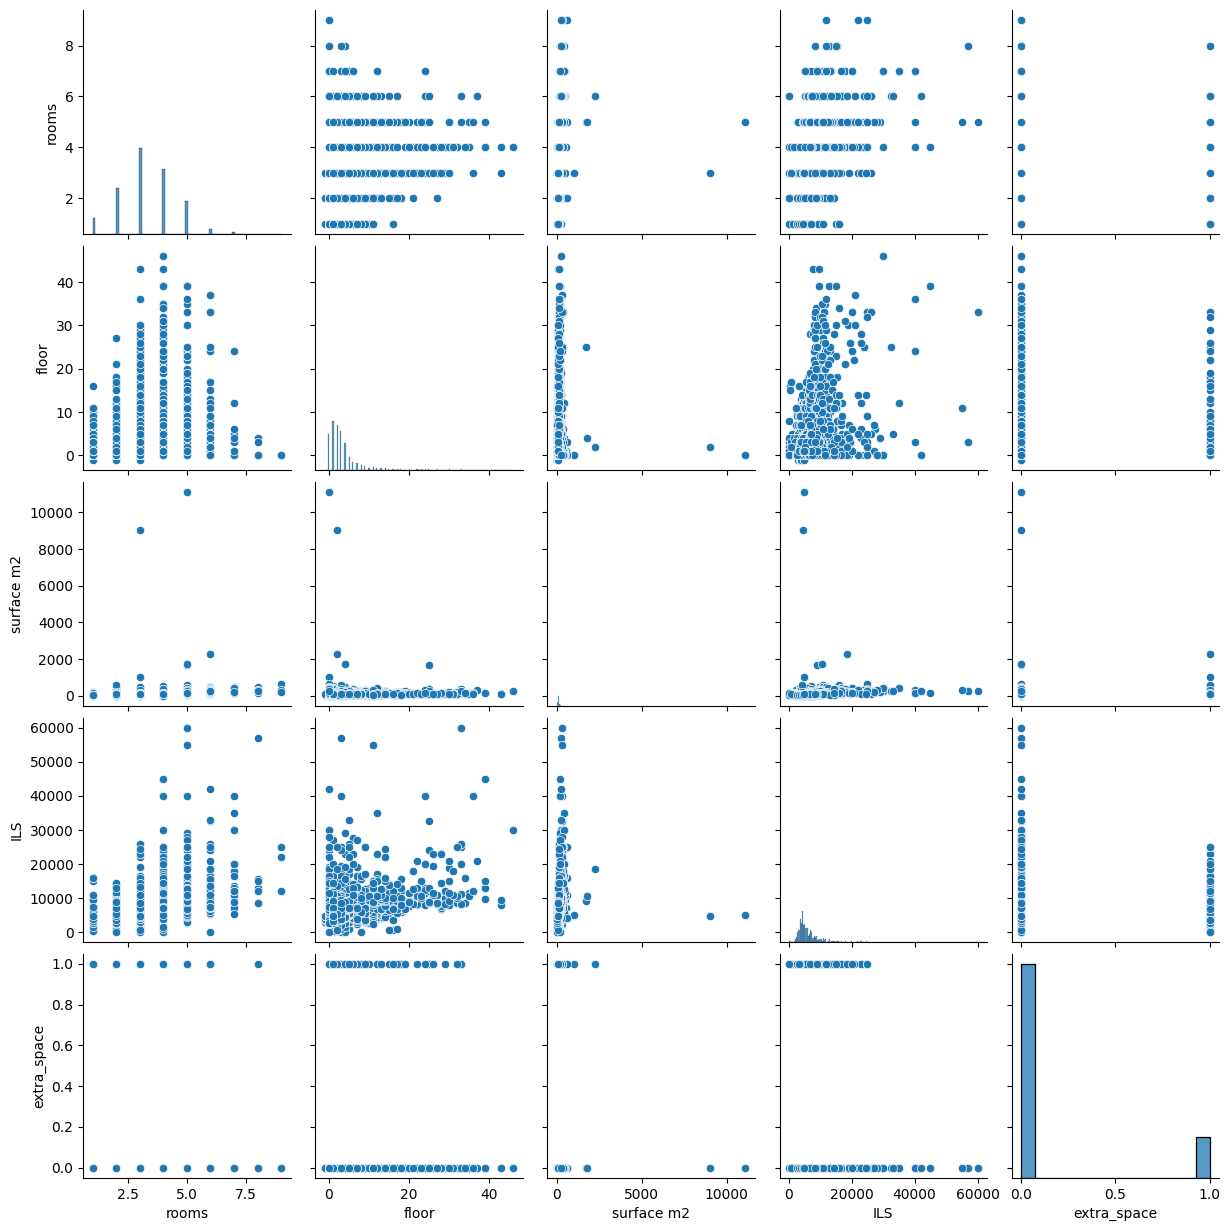

In [13]:
sns.pairplot(df_total_clean)

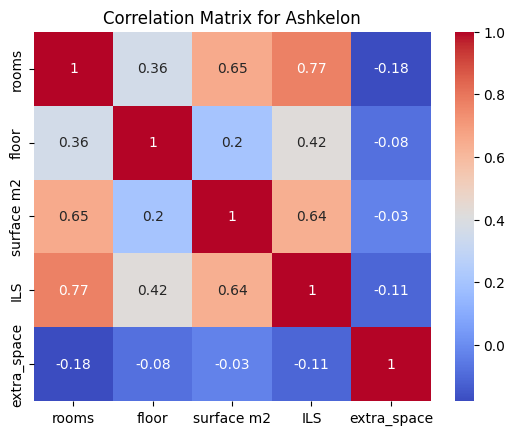

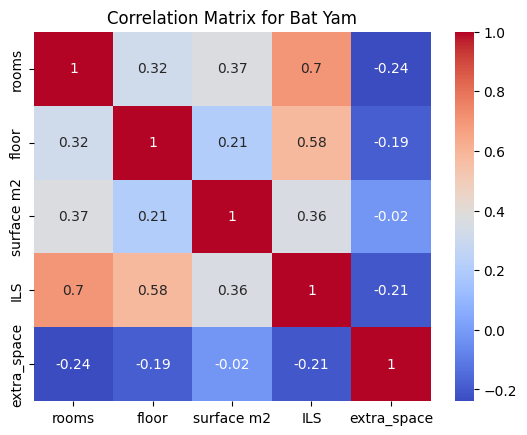

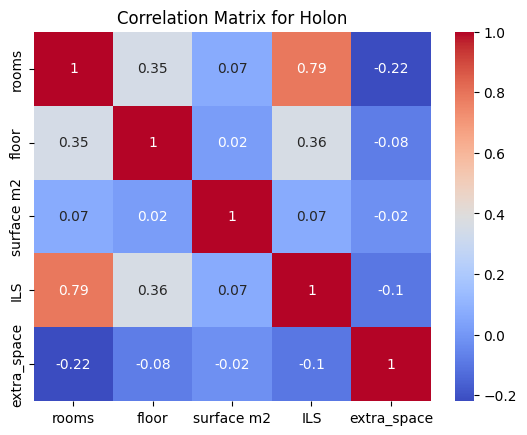

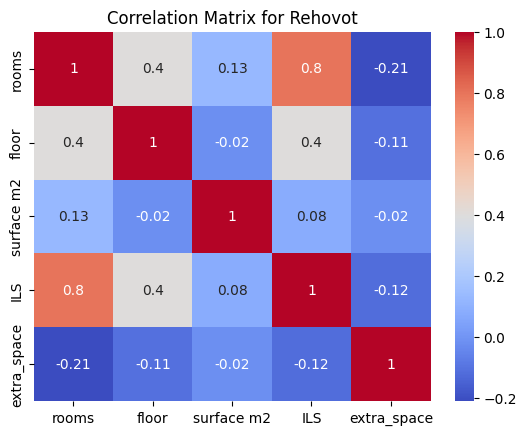

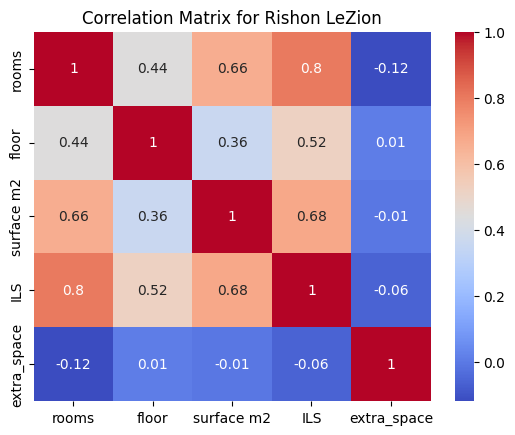

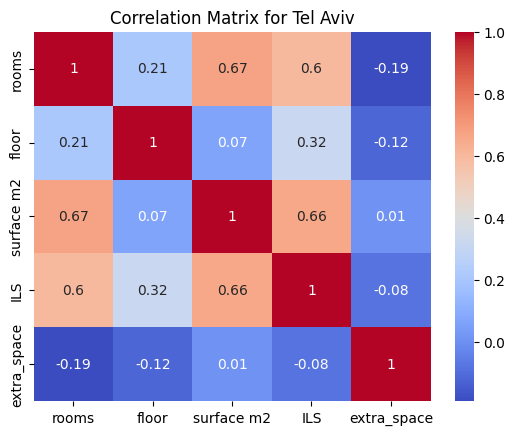

In [14]:
# Loop through each city to see individual correlations
for i in range(len(cities)):
    city = cities[i]
    temp_df = cleaned_data_frames[i]
        
    # corr matrix
    corr_matrix = temp_df[columns].corr().round(2)
    
    # plot corr matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {city}')
    plt.show()

The correlation between variables in the cities is generally similar but can differ significantly on an individual basis. Let's analyze the correlations we have:

1. **rooms and surface**: There's no noticeable correlaton in Holon and Rehovot, weak correlation in Bat Yam, and strong correlation in Ashkelon, Rishon LeZion And Tel Aviv.

2. **rental price and rooms**: We see a moderate to strong correlation for the entire dataset. According to the observation we can infer that more rooms result in a bigger price, except in Tel Aviv where the correlation diminishes to moderate. Indicating other factors significantly influence rental prices, such as location, amenities, or market demand.

3. **rental price and floor**: They show a weak correlation for Holon, Rehovot and Tel Aviv. For the rest of the cities it is a moderate correlation. We can infer the height, maybe because of the view from the apartment can have a role. Or maybe because of new, better and taller buildings in the city.

4. **rental price and surface**: The correlation is irrelevant in Holon and Rehovot and moderate for the rest of the dataset. Particularly, it is the strongest local correlation with price in Tel Aviv.

5. **rental price and extra space**: rental price feature doesn't seem to play any role at all.

`ILS` is our objective avriable, so we star by checking its distribution

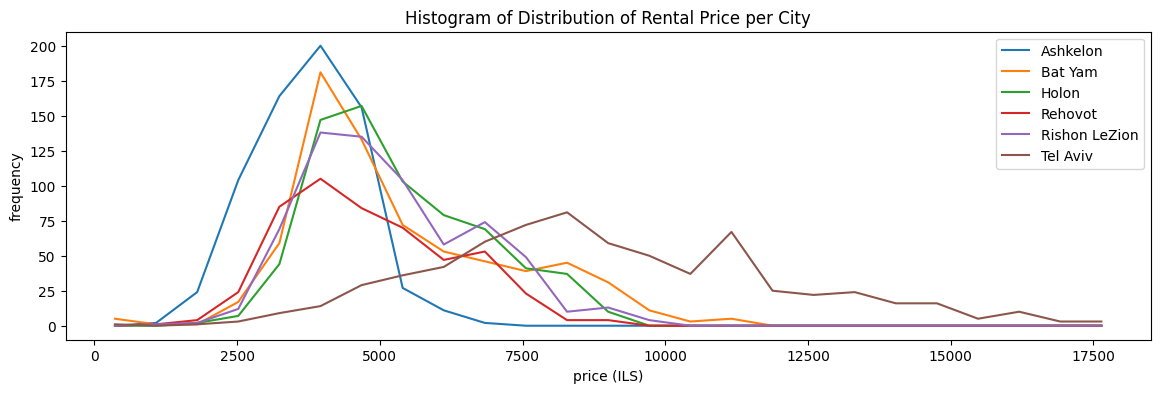

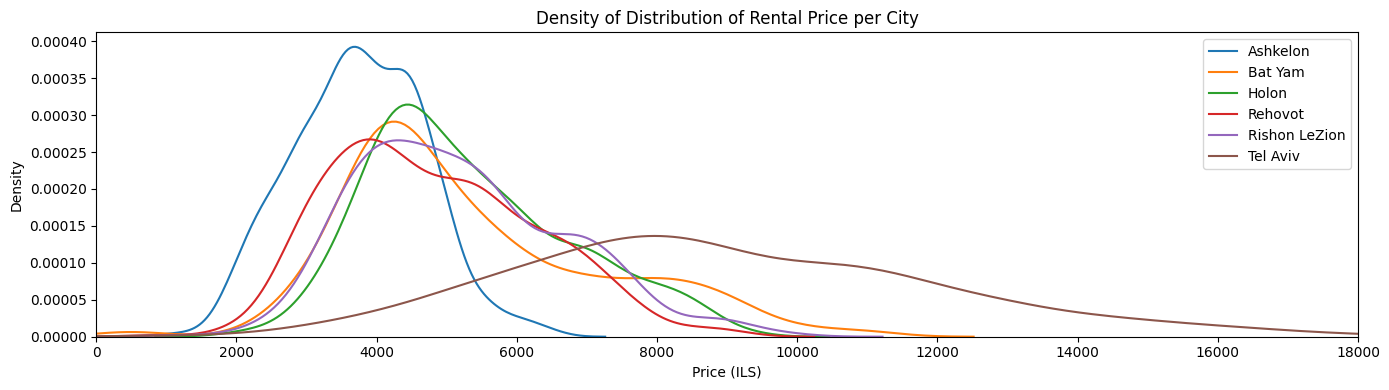

In [15]:
# we create our figure
fig, ax = plt.subplots(figsize=(14,4))

#  x limit
pricy = max(cleaned_data_frames[5]['ILS']) # most expensive property
bins = round(650**0.5) # amount of bins sqrt of aprox samples amount

# we iterate among the cities DFs and make a line histogram for each
for city, df in zip(cities, cleaned_data_frames):
    
    # we make the histogram
    hist, bins = np.histogram(df['ILS'], bins=bins, range=(0, pricy))

    # we center each bin
    mid_points = (bins[:-1] + bins[1:]) / 2 - 0.5

    # we plot the line among each bin
    ax.plot(mid_points, hist, label=city, linestyle='-', marker=None)

# labes & title
ax.set_xlabel('price (ILS)')
ax.set_ylabel('frequency')
ax.set_title('Histogram of Distribution of Rental Price per City')
ax.legend()

plt.show()

# ---------------------------------------------------------------------------------------

# kde plot
fig, ax = plt.subplots(figsize=(14, 4))

#  we iterate among the cities DFs and make a kde plot for each
for city, df in zip(cities, cleaned_data_frames):
    
    # Creamos el KDE
    sns.kdeplot(data=df['ILS'], ax=ax, label=city, clip=(0, pricy))

# labes & title
ax.set_xlabel('Price (ILS)')
ax.set_ylabel('Density')
ax.set_title('Density of Distribution of Rental Price per City')
ax.legend()

# x limit
ax.set_xlim(0, pricy)

plt.tight_layout()

plt.show()

Except for Tel Aviv, all price distributions are right-skewed with a mode close to 4000 ILS. Tel Aviv seems fairly centered with a mode close to 8000 and a secondary peak around 11250 ILS.

We can view some prices according room number for every city:

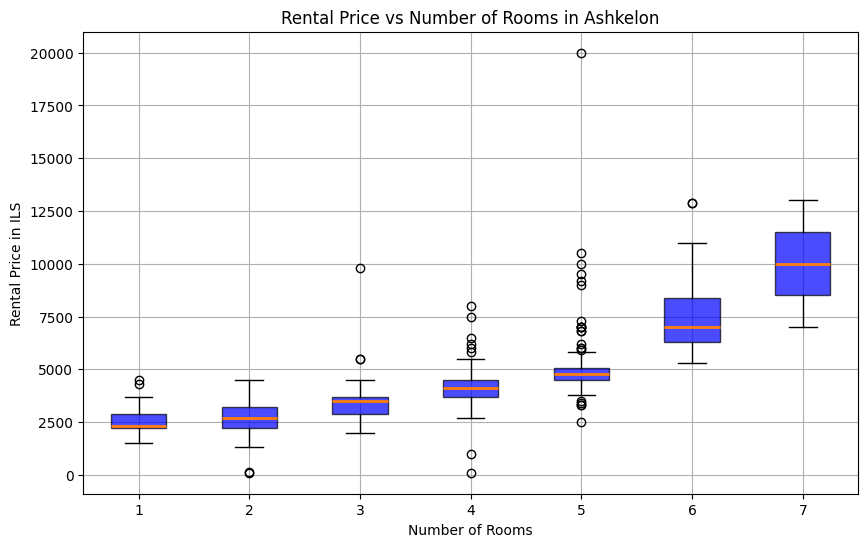

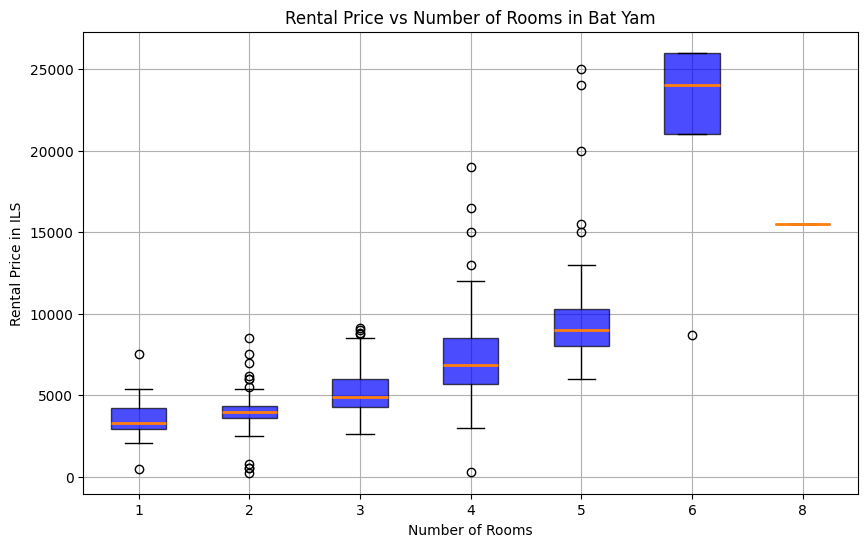

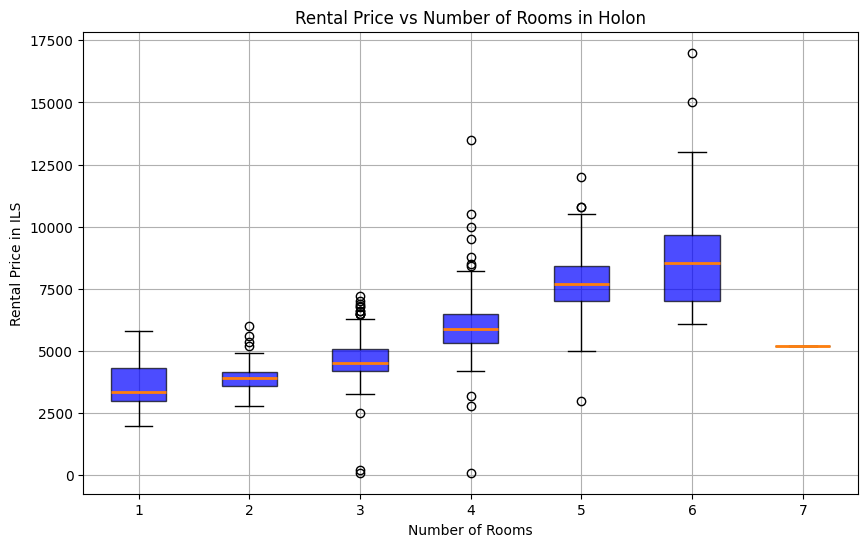

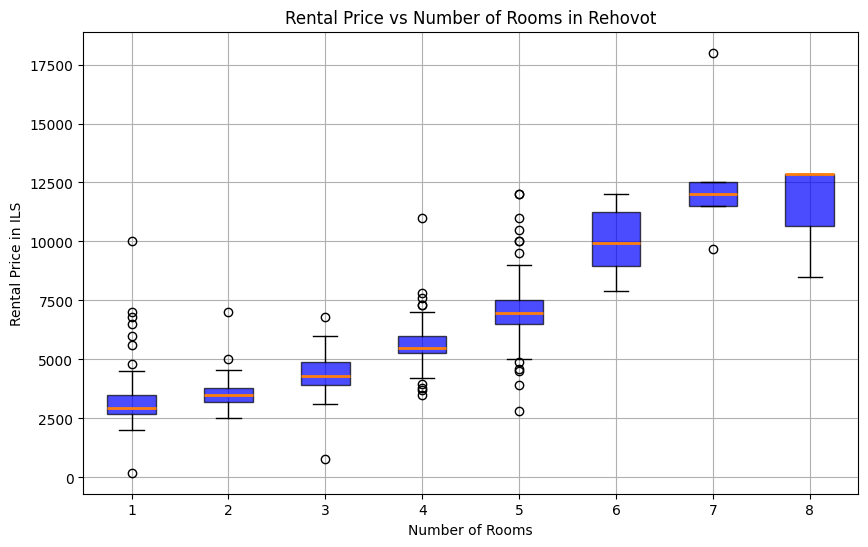

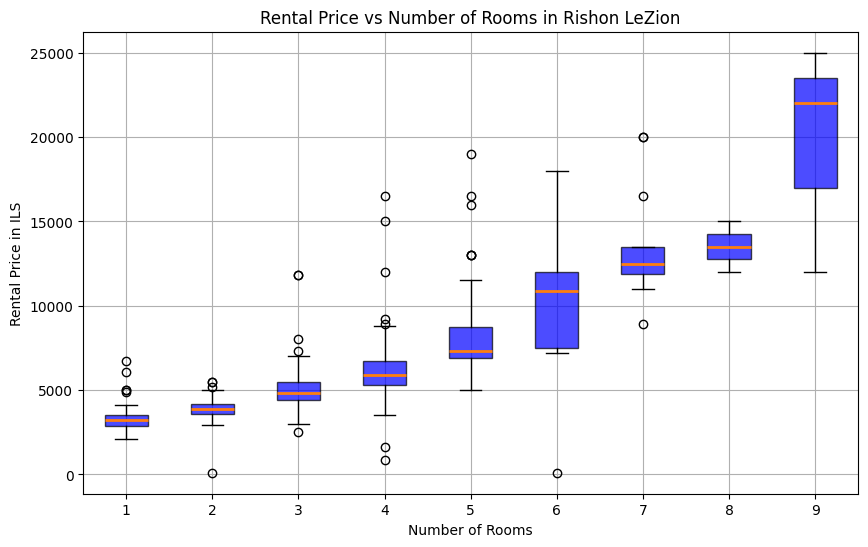

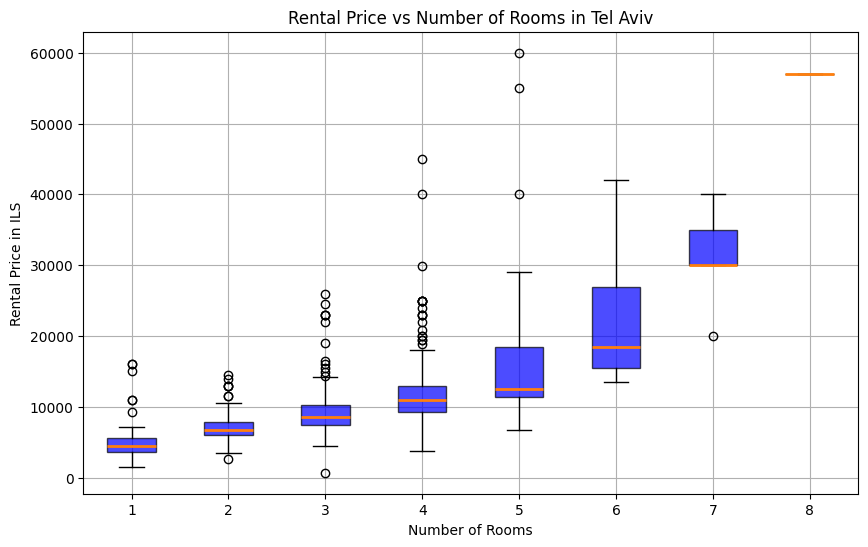

In [16]:
# Loop through each city and create a boxplot
for i in range(len(cities)):
    city_name = cities[i]
    city_df = data_frames[i]
        
    # Group the data by the number of rooms and extract the prices
    room_groups = city_df.groupby('rooms')['ILS'].apply(list)
    
    # Create a boxplot for the current city
    plt.figure(figsize=(10, 6))
    boxplot = plt.boxplot(room_groups, tick_labels=room_groups.index, patch_artist=True, medianprops=dict(linewidth=2), notch=False)
    
    # Customize the box colors with alpha values
    box_color = 'blue'
    alpha = 0.7
    for box in boxplot['boxes']:
        box.set(facecolor=box_color, alpha=alpha)
    
    plt.xlabel('Number of Rooms')
    plt.ylabel('Rental Price in ILS')
    plt.title(f'Rental Price vs Number of Rooms in {city_name}')
    plt.grid(True)
    
    # Show the plot for the current city
    plt.show()

If we seggregate those graphics by room number we can compare better between cities:

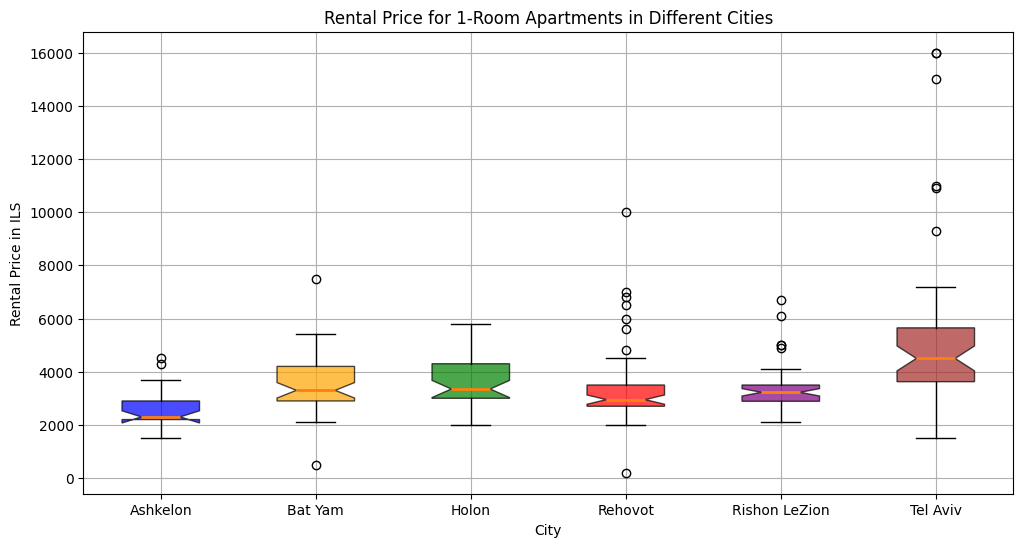

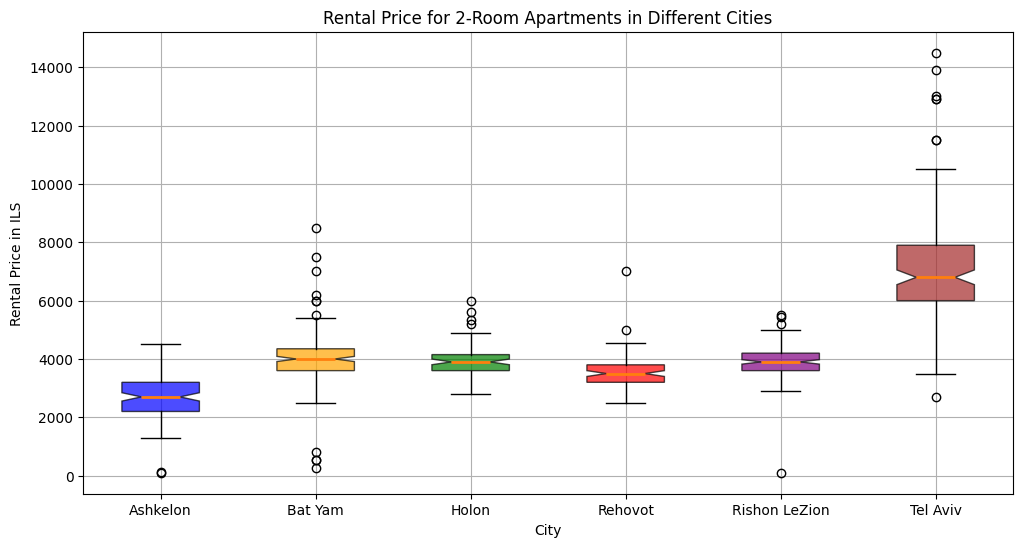

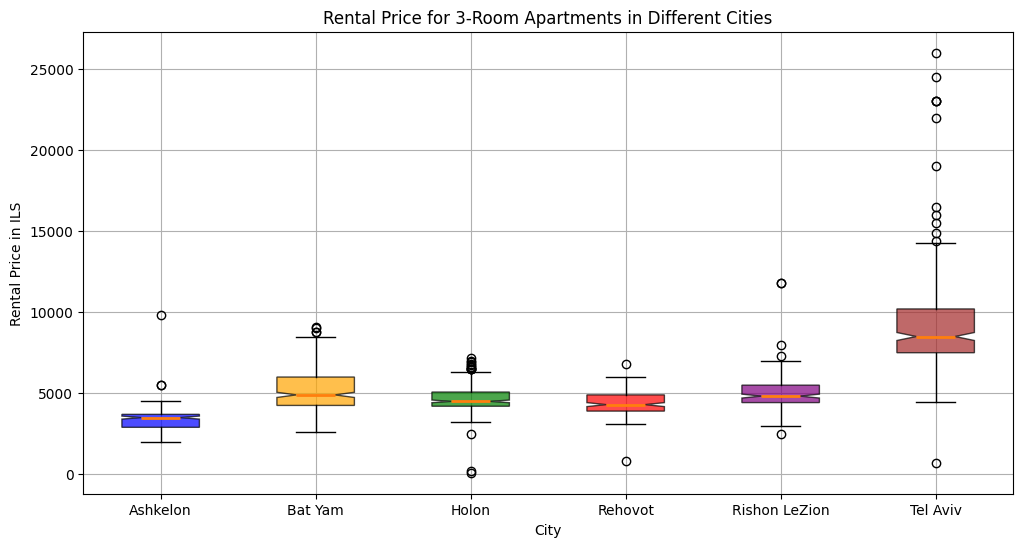

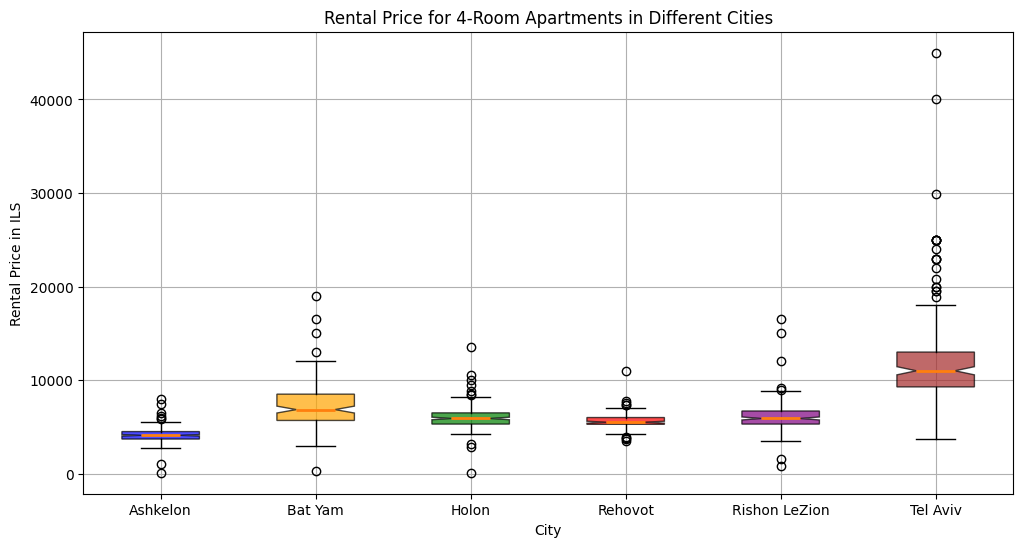

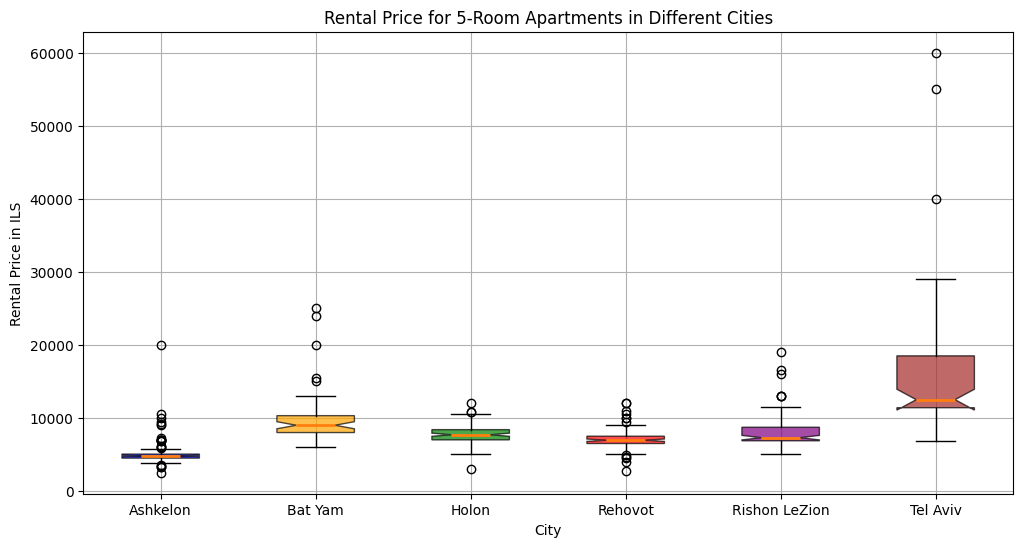

In [17]:
# rooms values to consider
room_values = [1, 2, 3, 4, 5]

# boxplot for each room value
for room_value in room_values:
    # rooms price list for each city
    prices_for_room = [df[df['rooms'] == room_value]['ILS'] for df in data_frames]

    # boxplot
    plt.figure(figsize=(12, 6))
    boxplot = plt.boxplot(prices_for_room, tick_labels=cities, patch_artist=True, medianprops=dict(linewidth=2), notch=True)

    # customize the box colors with alpha values
    box_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    alpha = 0.7
    for box, color in zip(boxplot['boxes'], box_colors):
        box.set(facecolor=color, alpha=alpha)
    
    plt.xlabel('City')
    plt.ylabel('Rental Price in ILS')
    plt.title(f'Rental Price for {room_value}-Room Apartments in Different Cities')
    plt.grid(True)
    plt.show()

The single room apartments seam to have the most similar price among the cities. The price outliers in Tel Aviv show some very exclusive properties to rent.

Below we view a scatter-plot without outliers and its respective tendency line:

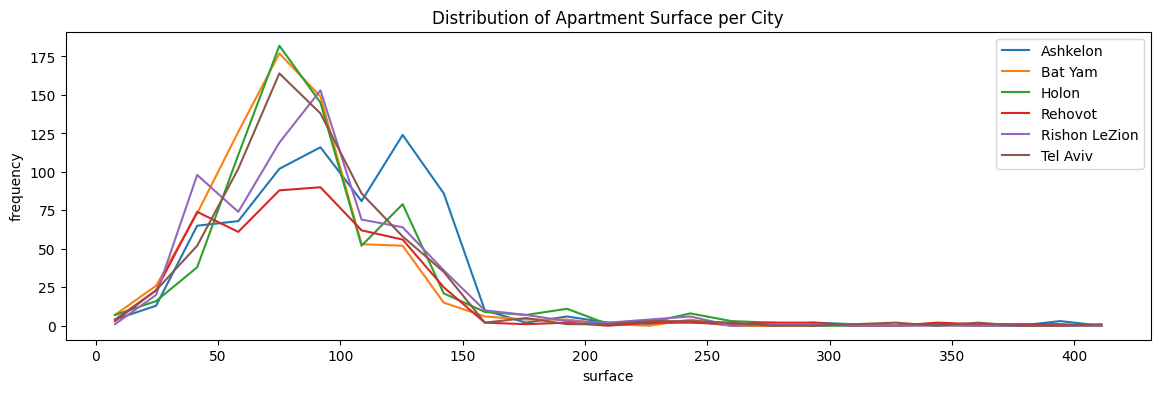

In [18]:
# we create our figure
fig, ax = plt.subplots(figsize=(14,4))

#  x limit
pricy = max(cleaned_data_frames[5]['surface m2']) # most expensive property
bins = round(650**0.5) # amount of bins sqrt of aprox samples amount

# we iterate among the cities DFs and make a line histogram for each
for city, df in zip(cities, cleaned_data_frames):
    
    # we make the histogram
    hist, bins = np.histogram(df['surface m2'], bins=bins, range=(0, pricy))

    # we center each bin
    mid_points = (bins[:-1] + bins[1:]) / 2 - 0.5

    # we plot the line among each bin
    ax.plot(mid_points, hist, label=city, linestyle='-', marker=None)

# labes & title
ax.set_xlabel('surface')
ax.set_ylabel('frequency')
ax.set_title('Distribution of Apartment Surface per City')
ax.legend()

plt.show()

The upper histogram reveals that to standardize the data across cities, we can focus on rental properties with surface areas ranging from 5 m2 to 175 m2. This range captures the majority of the data while excluding irregular data among the cities..

In [19]:
# threshold the surface in the dataframes list
for i in range(len(cities)):
    city_name = cities[i]
    city_df = cleaned_data_frames[i].copy()
    city_df = city_df[(city_df['surface m2'] <= 175) & (city_df['surface m2'] >= 5)]
    cleaned_data_frames[i] = city_df

The slope (m) for Ashkelon is 21.68 ILS/m2
Ashkelon´s R is 0.7781859807493746  and its R^2 is 0.6055734206348661
Square meter value in Ashkelon is approx 38.70 ILS/m2

The slope (m) for Bat Yam is 48.05 ILS/m2
Bat Yam´s R is 0.7422213408087398  and its R^2 is 0.5508925187519235
Square meter value in Bat Yam is approx 66.57 ILS/m2

The slope (m) for Holon is 38.67 ILS/m2
Holon´s R is 0.7825244762609335  and its R^2 is 0.6123445559474482
Square meter value in Holon is approx 61.02 ILS/m2

The slope (m) for Rehovot is 36.64 ILS/m2
Rehovot´s R is 0.8583382324488701  and its R^2 is 0.7367445212834506
Square meter value in Rehovot is approx 56.98 ILS/m2

The slope (m) for Rishon LeZion is 36.47 ILS/m2
Rishon LeZion´s R is 0.8174375161293733  and its R^2 is 0.6682040927757594
Square meter value in Rishon LeZion is approx 60.03 ILS/m2

The slope (m) for Tel Aviv is 72.18 ILS/m2
Tel Aviv´s R is 0.7200383184323224  and its R^2 is 0.5184551800108465
Square meter value in Tel Aviv is approx 104.34

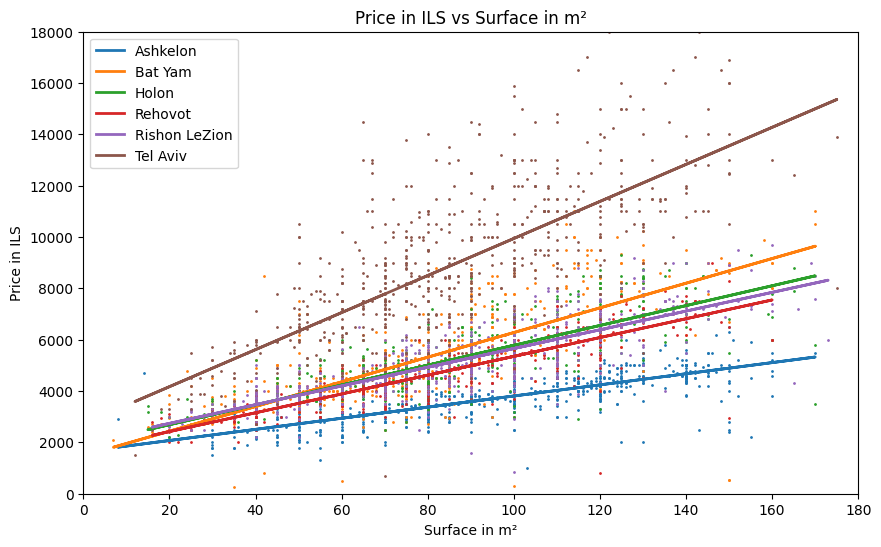

In [20]:
# create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# iterate through each city
for i in range(len(cities)):
    city_name = cities[i]
    city_df = cleaned_data_frames[i]
    
    # dispersion plot for individual city
    ax.scatter(city_df['surface m2'], city_df['ILS'], s=1)

    # plot limits
    ax.set_xlim(left=0, right=180)
    ax.set_ylim(bottom=0, top=18000)
    
    # fit a linear regression model
    x = city_df['surface m2']
    y = city_df['ILS']
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, linewidth=2, label=city_name)

    # print slope m value
    print(f"The slope (m) for {city_name} is {m:.2f} ILS/m2")
    
    # calculate R and R2
    r = np.corrcoef(y, m*x + b)[0, 1]
    r_squared = r**2

    # print results
    print(f"{city_name}´s R is", r, " and its R^2 is", r_squared)
       
    # square meter value a a function of the tendency line
    total_price = sum(city_df['ILS'])
    total_surface = sum(city_df['surface m2'])
    square_meter = total_price / total_surface
    print(f"Square meter value in {city_name} is approx {square_meter:.2f} ILS/m2")
    print("")

# title & labels
ax.set_title('Price in ILS vs Surface in m²')
ax.set_xlabel('Surface in m²')
ax.set_ylabel('Price in ILS')

# plot legend
ax.legend()

plt.show()

From the upper scatter-plot we can notice how dispersed are the datasets. The trend lines exhibit positive slope coefficients indicating an increase in the rental price with the area. This trending in Tel Aviv is almost twice the observed in most of the other cities (except Bat Yam), and is more than trice the observed in Ashkelon. 

In [21]:
# iterate through cities to obtain squared meter value as a function of rooms number
for i in range(len(cities)):
    city_name = cities[i]
    city_df = cleaned_data_frames[i]
    
    for j  in range(1, 6):
        filtered_rooms = city_df[city_df['rooms'] == j]

        # Ccalculate squared meter value
        total_price = sum(filtered_rooms['ILS'])
        total_surface = sum(filtered_rooms['surface m2'])
        square_meter = total_price / total_surface
        print(f"Square meter value in {city_name} for a {j} rooms apartment is approx {square_meter:.2f} ILS/m2")
    print()

Square meter value in Ashkelon for a 1 rooms apartment is approx 51.95 ILS/m2
Square meter value in Ashkelon for a 2 rooms apartment is approx 48.27 ILS/m2
Square meter value in Ashkelon for a 3 rooms apartment is approx 41.18 ILS/m2
Square meter value in Ashkelon for a 4 rooms apartment is approx 36.64 ILS/m2
Square meter value in Ashkelon for a 5 rooms apartment is approx 34.96 ILS/m2

Square meter value in Bat Yam for a 1 rooms apartment is approx 84.73 ILS/m2
Square meter value in Bat Yam for a 2 rooms apartment is approx 71.65 ILS/m2
Square meter value in Bat Yam for a 3 rooms apartment is approx 64.27 ILS/m2
Square meter value in Bat Yam for a 4 rooms apartment is approx 65.08 ILS/m2
Square meter value in Bat Yam for a 5 rooms apartment is approx 64.28 ILS/m2

Square meter value in Holon for a 1 rooms apartment is approx 79.63 ILS/m2
Square meter value in Holon for a 2 rooms apartment is approx 65.99 ILS/m2
Square meter value in Holon for a 3 rooms apartment is approx 61.18 ILS/m

We can see in general why it is cheaper to get a roomie.

Now we tackle property type:


In [22]:
for i in range(len(cities)):
    city = cities[i]
    city_df = cleaned_data_frames[i]
    print(city, ':', city_df['type'].value_counts())
    print('-------------------------------------')

Ashkelon : type
apartment           543
housing unit         80
garden apartment     19
house                 9
penthouse             7
duplex                4
other                 4
basement              2
Name: count, dtype: int64
-------------------------------------
Bat Yam : type
apartment           622
garden apartment     20
housing unit         14
other                13
penthouse            12
duplex                1
house                 1
Name: count, dtype: int64
-------------------------------------
Holon : type
apartment           568
penthouse            25
garden apartment     18
housing unit         17
other                13
house                13
duplex                3
Name: count, dtype: int64
-------------------------------------
Rehovot : type
apartment           382
housing unit         60
house                11
garden apartment      9
basement              9
penthouse             5
other                 5
duplex                1
Name: count, dtype: int64
---

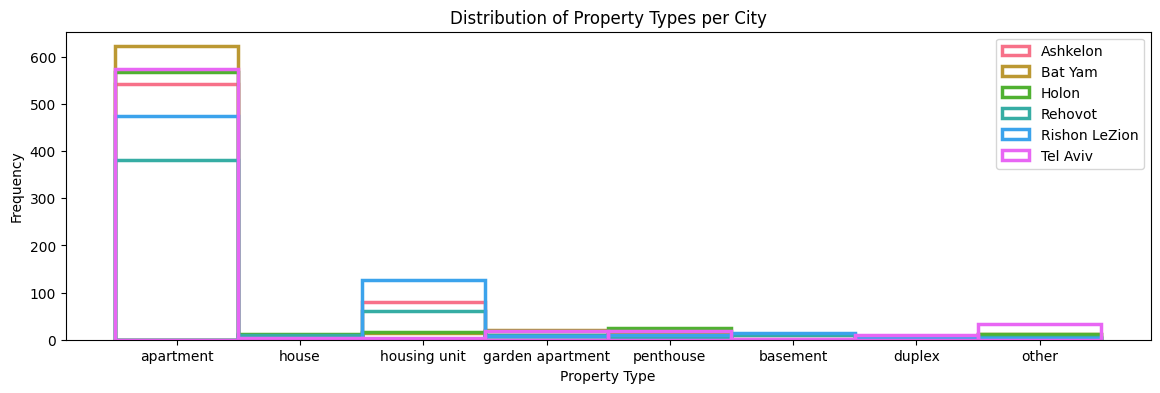

In [23]:
# we create our figure
fig, ax = plt.subplots(figsize=(14,4))

# define color palette
palette = sns.color_palette('husl', len(cities))

# plot for each city
for i in range(len(cities)):
    city = cities[i]
    city_df = cleaned_data_frames[i]
    sns.histplot(city_df['type'], label=city, ax=ax, alpha=0.0, color='white', edgecolor=palette[i], linewidth=2.5)

# labes & title
ax.set_xlabel('Property Type')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Property Types per City')
ax.legend()

plt.show()

The upper histogram is from the reduced dataset (which is the one to use for the ML models): without price outliers, and properties of 175 m2 or less. The most common property type is apartment, and even dividing the whole set as apartment / not apartment, we end up with an unbalanced class on each city. Another option would be take only the apartmet property type, excluding the others. The variability in this cathegory between cities may complicate finding a unique ML model in comon



In [24]:
for i in range(len(cleaned_data_frames)):
    
    # select the dataframe
    temp_df = cleaned_data_frames[i].copy()
    
    # we create the 'extra_space' column
    temp_df['is_apartment'] = (temp_df['type'] == 'apartment')

    # replace the dataframe in the list
    cleaned_data_frames[i] = temp_df

cleaned_data_frames[1].head()

,rooms,floor,surface m2,ILS,type,extra_space,is_apartment
0,2,18,50,6000,apartment,0,True
1,2,3,56,3700,apartment,0,True
2,5,24,147,8700,apartment,0,True
3,3,1,80,5600,apartment,0,True
4,4,2,82,5000,apartment,0,True


The last variable to tackle is the floor number:

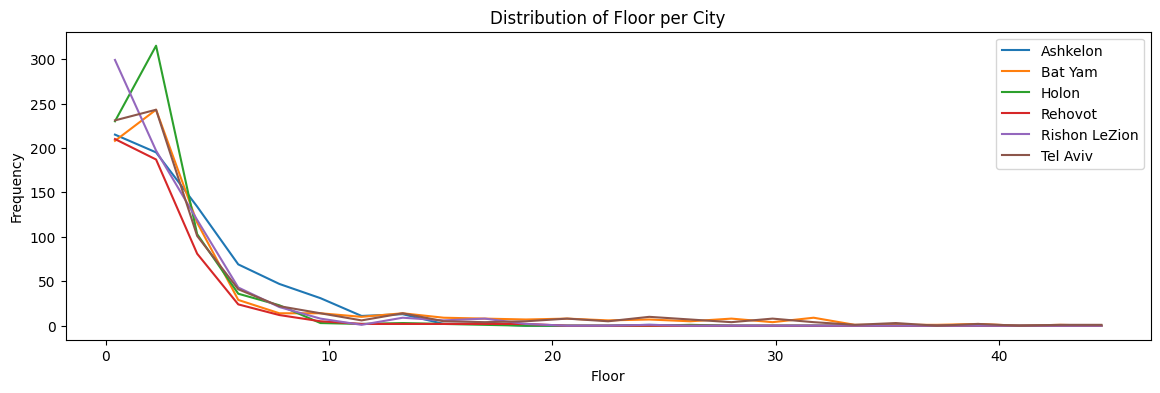

In [25]:
# we create our figure
fig, ax = plt.subplots(figsize=(14,4))

#  x limit
pricy = max(data_frames[5]['floor']) # taller property
bins = round(650**0.5) # amount of bins sqrt of aprox samples amount

# we iterate among the cities DFs and make a line histogram for each
for city, df in zip(cities, data_frames):
    
    # we make the histogram
    hist, bins = np.histogram(df['floor'], bins=bins, range=(0, pricy))

    # we center each bin
    mid_points = (bins[:-1] + bins[1:]) / 2 - 0.5

    # we plot the line among each bin
    ax.plot(mid_points, hist, label=city, linestyle='-', marker=None)

# labes & title
ax.set_xlabel('Floor')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Floor per City')
ax.legend()

plt.show()

In the upper histogram we can't appreciate the existence some basements (floor -1). We can see some really tall apartments in some towers. The distribution is extremelly right skewed, a possibility is to try a log transform. For generalization we can opt to take only the properties which are contained in the mean plus two std of the original sample (to keep the original statistics).

In [26]:
# general statistics
mean = df_total_clean['floor'].mean()
std = df_total_clean['floor'].std()
print('mean floor is', mean)
print('floor std is', std)

# define threshold
threshold = round(mean + 2 * std)
# threshold = 9
print('max floor threshold is', threshold)

mean floor is 3.8269138180067404
floor std is 5.2210595943754505
max floor threshold is 14


In [27]:
# iterate through cities
for i in range(len(cities)):
    city = cities[i]
    temp_df = cleaned_data_frames[i]
    temp_df = temp_df[temp_df['floor'] <= threshold]
    cleaned_data_frames[i] = temp_df
    print(f'In {city} dataset remain {len(temp_df)} samples')

In Ashkelon dataset remain 667 samples
In Bat Yam dataset remain 622 samples
In Holon dataset remain 655 samples
In Rehovot dataset remain 478 samples
In Rishon LeZion dataset remain 633 samples
In Tel Aviv dataset remain 611 samples


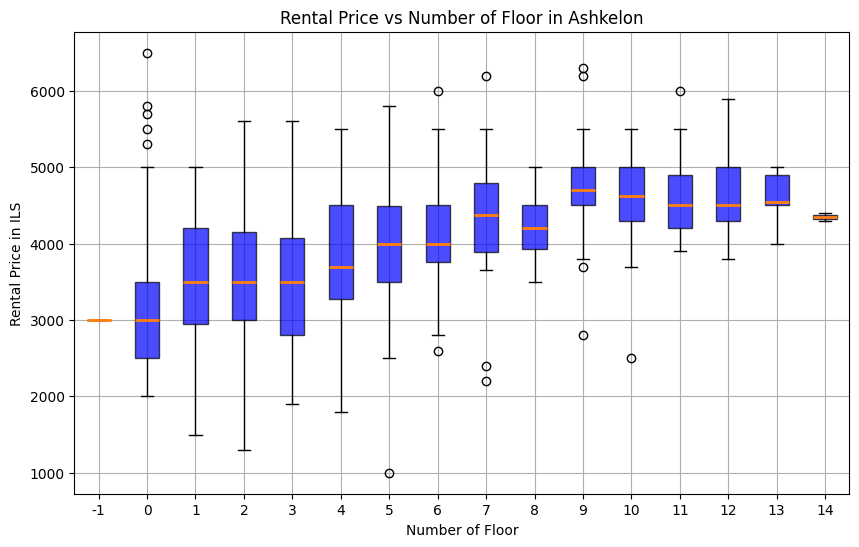

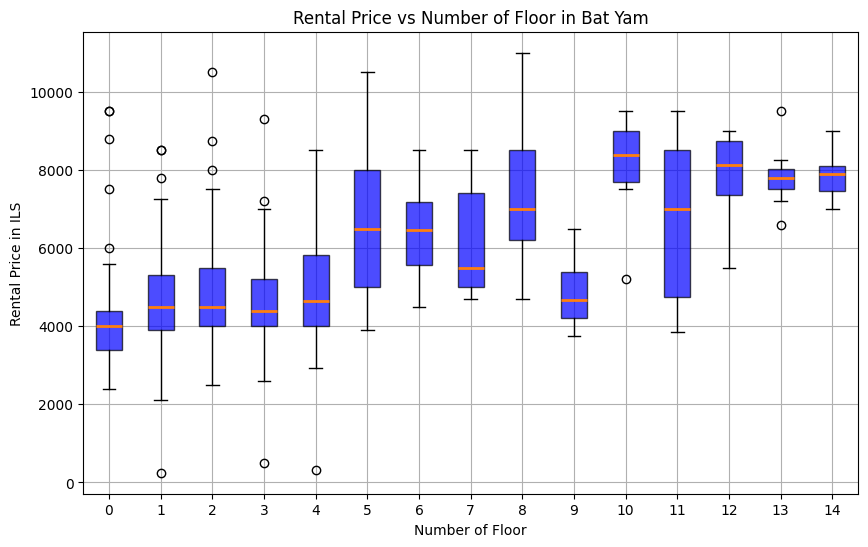

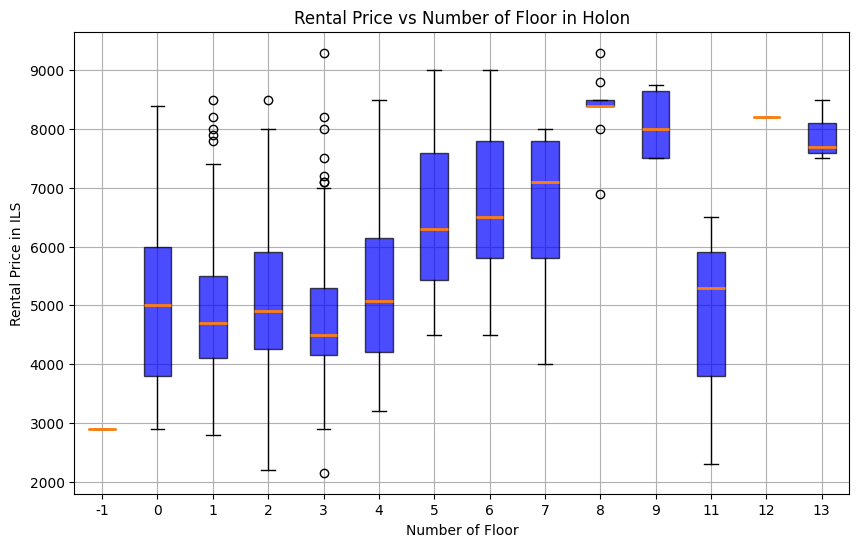

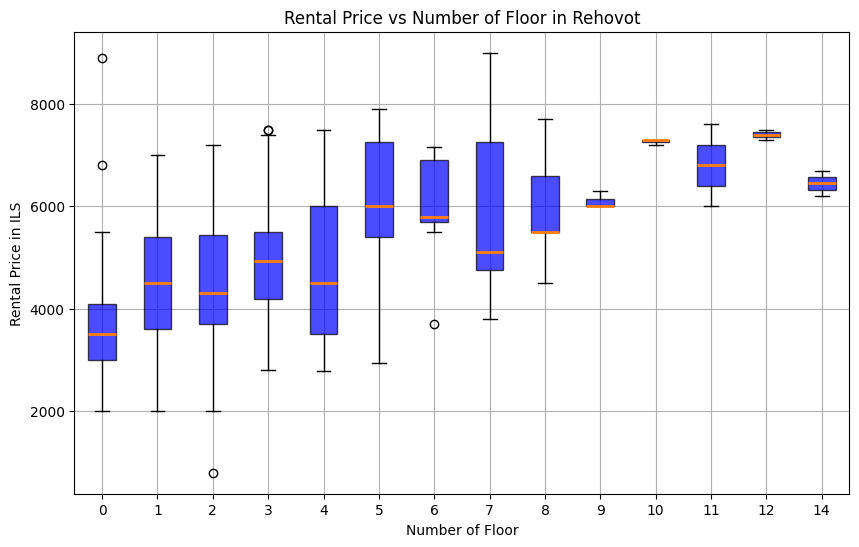

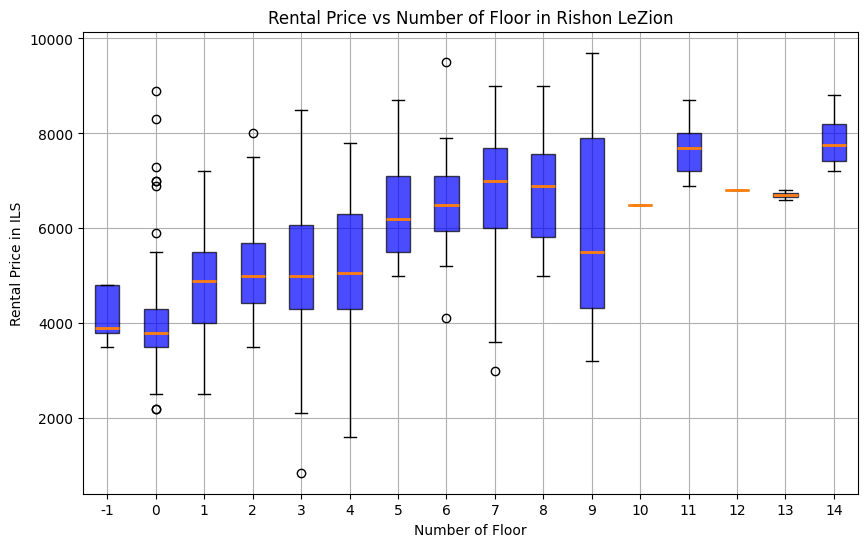

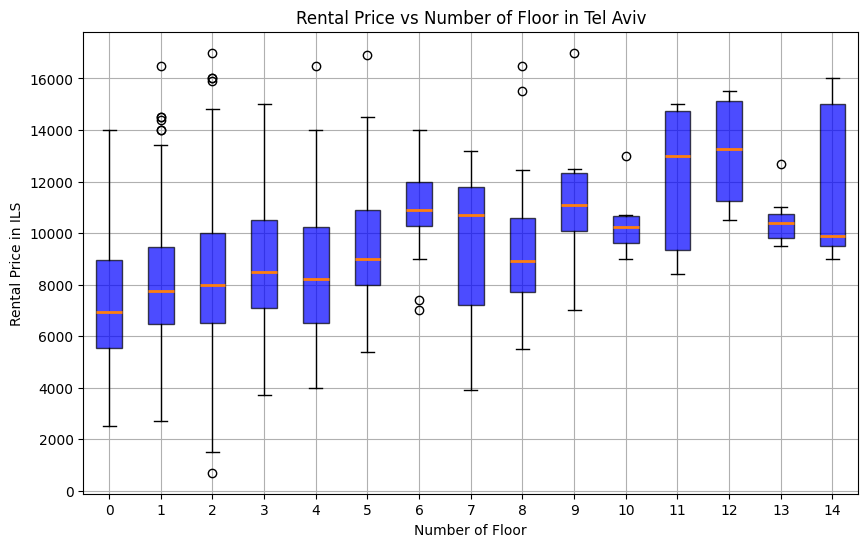

In [28]:
# Loop through each city and create a boxplot
for i in range(len(cities)):
    city_name = cities[i]
    city_df = cleaned_data_frames[i]
    
    # Group the data by the number of rooms and extract the prices
    room_groups = city_df.groupby('floor')['ILS'].apply(list)
    
    # Create a boxplot for the current city
    plt.figure(figsize=(10, 6))
    boxplot = plt.boxplot(room_groups, tick_labels=room_groups.index, patch_artist=True, medianprops=dict(linewidth=2), notch=False)
    
    # Customize the box colors with alpha values
    box_color = 'blue'
    alpha = 0.7
    for box in boxplot['boxes']:
        box.set(facecolor=box_color, alpha=alpha)
    
    plt.xlabel('Number of Floor')
    plt.ylabel('Rental Price in ILS')
    plt.title(f'Rental Price vs Number of Floor in {city_name}')
    plt.grid(True)
    
    # Show the plot for the current city
    plt.show()

In the reduced range of floors analyzed, there is a noticeable trend of the median floor level increasing up to the 9th floor. However, when considering the whiskers of the boxplot, this increase is not statistically significant.

# ANOVA

Now we examine if there is a statistical difference between cities. For the ANOVA we combine now our reduced dataset, specifying the city:

In [29]:
# create the 'city' column on each city dataframe:
for i in range(len(cities)):
    city_name = cities[i]
    city_df = cleaned_data_frames[i].copy()
    city_df = city_df.drop('type', axis=1)
    city_df.loc[:, 'city'] = city_name
    cleaned_data_frames[i] = city_df

total number of NaNs is: 0

   rooms  floor  surface m2   ILS  extra_space  is_apartment      city
0      2      1        60.0  2200            0             1  Ashkelon
1      4      5       120.0  3700            0             1  Ashkelon
2      3      5        90.0  3500            0             1  Ashkelon
3      5     10       139.0  5000            0             1  Ashkelon
4      4      2        95.0  3000            0             1  Ashkelon

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3666 entries, 0 to 3665
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rooms         3666 non-null   int64   
 1   floor         3666 non-null   int64   
 2   surface m2    3666 non-null   float64 
 3   ILS           3666 non-null   int64   
 4   extra_space   3666 non-null   int64   
 5   is_apartment  3666 non-null   int64   
 6   city          3666 non-null   category
dtypes: category(1), float64(1), int64(5)
m

C:\Users\kinda\AppData\Local\Temp\ipykernel_15168\2596445265.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total_clean = pd.concat([df_total_clean, temp_df], ignore_index=True)


<Axes: xlabel='ILS', ylabel='Count'>

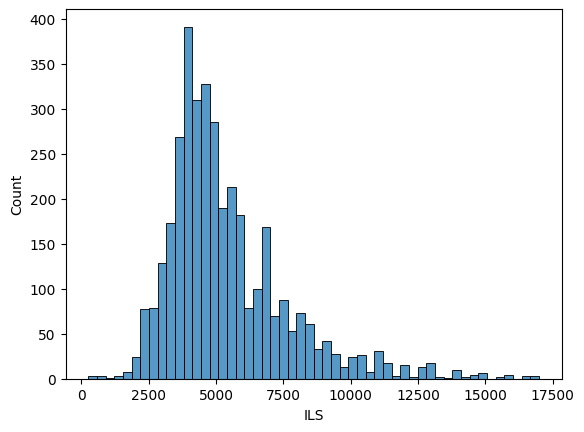

In [30]:
# create empty dataframe
columns = ['rooms', 'floor', 'surface m2', 'ILS', 'extra_space', 'is_apartment']
df_total_clean = pd.DataFrame(columns=columns)
df_total_clean = df_total_clean.copy()

for i, city in enumerate(cities):
    temp_df = cleaned_data_frames[i].copy()
    temp_df['city'] = city
    df_total_clean = pd.concat([df_total_clean, temp_df], ignore_index=True)

# make sure ILS is numeric (it was but wasnt readed like that, why?????)
df_total_clean['rooms'] = pd.to_numeric(df_total_clean['rooms'], errors='coerce')
df_total_clean['floor'] = pd.to_numeric(df_total_clean['floor'], errors='coerce')
df_total_clean['ILS'] = pd.to_numeric(df_total_clean['ILS'], errors='coerce')
df_total_clean['extra_space'] = df_total_clean['extra_space'].astype(int) # this is not really necessary for the ANOVA
df_total_clean['is_apartment'] = df_total_clean['is_apartment'].astype(int) # this is not really necessary for the ANOVA
df_total_clean['city'] = df_total_clean['city'].astype('category')

# Verify there are no NaNs in ILS
print('total number of NaNs is:', df_total_clean['ILS'].isna().sum())
print()
print(df_total_clean.head())
print()
print(df_total_clean.info())
sns.histplot(df_total_clean['ILS'])

The total price distribution is right-skewed so, for the ANOVA we apply log transform:

<Axes: xlabel='log_ILS', ylabel='Count'>

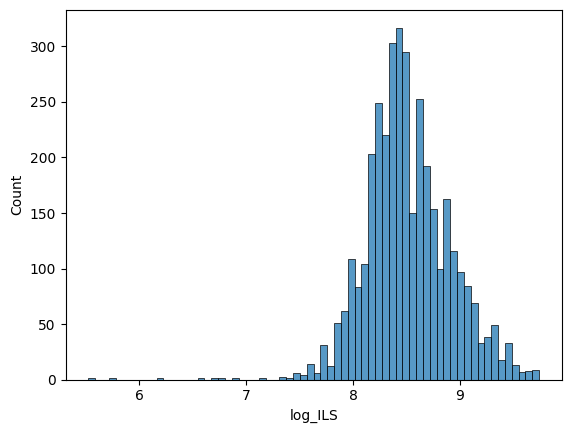

In [31]:
df_total_clean['log_ILS'] = np.log(df_total_clean['ILS'])
sns.histplot(df_total_clean['log_ILS'])

In [32]:
df_total_clean = df_total_clean[df_total_clean['log_ILS'] > 7]

Now with a distribution closer to a normal one, we proceed with the ANOVA. In order to run ANOVA, we need to create a regression model. We'll create a simple linear regression model where the X variable is 'city', which we will code as categorical using C(). Then, we'll fit the model to the data, and generate model summary statistics.

In [33]:
# construct simple linear regression model, and fit the model
model = ols(formula = "log_ILS ~ C(city)", data = df_total_clean).fit()

# get summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ILS   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     529.7
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:35:58   Log-Likelihood:                -652.93
No. Observations:                3659   AIC:                             1318.
Df Residuals:                    3653   BIC:                             1355.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.1918      0.011    730.298      0.000       8.170       8.214
C(city)[T.Bat Yam]           0.2928      0.016     18.117      0.000       0.261       0.324
C(city)[T.Holon]             0.3356      0.016     21.066      0.000       0.304       0.367
C(city)[T.Rehovot]           0.2257      0.017     12.997      0.000       0.192       0.260
C(city)[T.Rishon LeZion]     0.3042      0.016     18.922      0.000       0.273       0.336
C(city)[T.Tel Aviv]          0.8141      0.016     50.178      0.000       0.782       0.846
==============================================================================
Omnibus:                       49.717   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.361
Skew:                          -0.250   Prob(JB):                     1.57e-12
Kurtosis:                       3.327   Cond. No.                         6.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the model summary table, the cities associated beta coefficients all have a p-value of less than 0.05 (check the `P>|t|` column). But we can't be sure if there is a significant price difference between the various cities. This is where one-way ANOVA comes in.

First, we have to state our null and alternative hypotheses:

#### Null Hypothesis

$$H_0: price_D=price_E=price_F=price_H=price_I$$

There is no difference in the rental price of properties based on the city.

#### Alternative Hypothesis

$$H_1: \text{Not } price_D=price_E=price_F=price_H=price_I$$

There is a difference in the rental price of properties based on the city.

In [34]:
# Run one-way ANOVA
sm.stats.anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(city),221.919222,5.0,529.654043,0.0
Residual,306.113369,3653.0,NaN,NaN


In [35]:
sm.stats.anova_lm(model, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(city),5.0,221.919222,44.383844,529.654043,0.0
Residual,3653.0,306.113369,0.083798,NaN,NaN


In [36]:
sm.stats.anova_lm(model, typ = 3)

,sum_sq,df,F,PR(>F)
Intercept,44692.352228,1.0,533335.617105,0.0
C(city),221.919222,5.0,529.654043,0.0
Residual,306.113369,3653.0,NaN,NaN


We use the anova_lm() function from the statsmodels.stats package. As noted previously, the function requires a fitted regression model, and for us to specify the type of ANOVA: 1, 2, or 3. Since the p-value (column `PR(>F)`) is very small, we can reject the null hypothesis that the mean of the rental price is the same for all different cities.

Rejected the null hypothesis, we proceed to a Tukey's Honest Significant Difference (HSD) test for the post hoc analysis:

In [37]:
# Tukey HSD test
tukey = pairwise_tukeyhsd(endog=df_total_clean['log_ILS'], groups=df_total_clean['city'], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
     Ashkelon       Bat Yam   0.2928    0.0  0.2467  0.3389   True
     Ashkelon         Holon   0.3356    0.0  0.2902   0.381   True
     Ashkelon       Rehovot   0.2257    0.0  0.1762  0.2752   True
     Ashkelon Rishon LeZion   0.3042    0.0  0.2583    0.35   True
     Ashkelon      Tel Aviv   0.8141    0.0  0.7678  0.8603   True
      Bat Yam         Holon   0.0428  0.089 -0.0035   0.089  False
      Bat Yam       Rehovot  -0.0671  0.002 -0.1174 -0.0168   True
      Bat Yam Rishon LeZion   0.0114 0.9826 -0.0353   0.058  False
      Bat Yam      Tel Aviv   0.5212    0.0  0.4742  0.5683   True
        Holon       Rehovot  -0.1099    0.0 -0.1596 -0.0602   True
        Holon Rishon LeZion  -0.0314 0.3744 -0.0774  0.0146  False
        Holon      Tel Aviv   0.4785    0.0   0.432  0.5249   

**Significant Differences (reject=True)**: Tel Aviv has significantly different log-transformed rental prices compared to all other cities. The most notable difference is with Ashkelon, with a mean difference of 0.8141, indicating that Tel Aviv has much higher rental prices.

**Non-Significant Differences (reject=False)**: The differences in rental prices between Bat Yam, Rishon LeZion and Holon are not statistically significant.

# XGBRegressor

Since we have six different cities (or four according to ANOVA) for our target variable `log_ILS`, we should run six different ML hyperparameter sets (or four according to ANOVA). Therefore, instead of trying different types of ML models, each with different hyperparameters, we'll stick to XGBRegressor, known for its strong performance. We must train each city ML independently, another approach can be the combined set "Bat Yam - Holon - Rishon LeZion" to validate the ANOVA results.

Given the unique characteristics of each city, it's challenging to apply a uniform data manipulation approach. Removing data unsuitable for fitting or reducing ML parameters to accommodate certain cities might lead to loss of important information or interactions crucial for other cities' fits. The original dataset inherently shows variability in the target variable ILS, with the coefficient of variation (std/mean ratio) ranging from 0.33 in Holon to 0.60 in Tel Aviv. Even after removing price outliers and narrowing ranges for other variables, this inherent data dispersion will impact the regression model's performance.

We proceed to scale the data:

In [38]:
# create empty dataframe
columns = ['city', 'rooms', 'floor', 'surface m2', 'log_ILS', 'ILS', 'extra_space', 'is_apartment']
scaled_df_total_clean = pd.DataFrame(columns=columns)
scaled_df_total_clean = scaled_df_total_clean.copy()

# instantiate StandardScaler
scaler = StandardScaler()

# define numeric features
numeric_features = ['rooms', 'floor', 'surface m2', 'log_ILS', "ILS", 'extra_space', 'is_apartment']

# check some basic statistics in the reduced datasets
for city_name, df_city in df_total_clean.groupby('city', observed=True):
    
    # extract features to scale
    df_numeric = df_city[numeric_features]
    
    # apply StandardScaler
    scaled_numeric = scaler.fit_transform(df_numeric)
    
    # create temporal DF
    temp_df = pd.DataFrame(scaled_numeric, columns=numeric_features)
    temp_df['city'] = city_name
    
    # concat it to the scaled df
    scaled_df_total_clean = pd.concat([scaled_df_total_clean, temp_df], ignore_index=True)

C:\Users\kinda\AppData\Local\Temp\ipykernel_15168\3131063908.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scaled_df_total_clean = pd.concat([scaled_df_total_clean, temp_df], ignore_index=True)


The first approach we make is with the log transformed rental price as target variable:

In [39]:
%%time

# instantiate model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.05, 0.07],
    'max_depth': [2, 3, 4],
    'min_child_weight': [5, 10, 15],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2],  # Adding gamma for regularization
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# configure GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    error_score='raise'
)

# create the 'city' column on each city dataframe:
for i in range(len(cities)):
    city_name = cities[i]
    # city_df = df_total_clean.copy()
    city_df = scaled_df_total_clean.copy()
    city_df = city_df[city_df['city'] == city_name]
    city_df = city_df.drop(['ILS', 'city'], axis=1)
    df_ml = city_df

    X = df_ml.drop(['log_ILS'], axis=1)
    y = df_ml['log_ILS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_ml['floor'], random_state=42)
    
    # fit the model
    grid_search.fit(X_train, y_train)
    
    # get best model
    best_xgb = grid_search.best_estimator_
    print(f"{city_name} city XGBegressor report:")
    print("Best parameters:", grid_search.best_params_)
    
    # evaluate the model in the train set
    y_train_pred = best_xgb.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # evaluate the model in the test set
    y_pred = best_xgb.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    # print the results
    print(f"Train set: MSE={train_mse}, RMSE={train_rmse}, R2={train_r2}, MAE={train_mae}")
    print(f"Test set: MSE={test_mse}, RMSE={test_rmse}, R2={test_r2}, MAE={test_mae}")
    print(f"train mse - test mse ratio is: {test_mse/train_mse:.3f}")
    
    # print sorted feature importances
    importances = best_xgb.feature_importances_
    feature_names = X_train.columns
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    print('\nFeature importances:')
    print(feature_importance.head(10))  # Muestra las 10 características más importantes
    print('\n--------------------------------------------------------------------------------------------------------\n')

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Ashkelon city XGBegressor report:
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.7}
Train set: MSE=0.2576543960303373, RMSE=0.5075966863862857, R2=0.7499994501262132, MAE=0.3841139719730108
Test set: MSE=0.34913904183216654, RMSE=0.5908798878216845, R2=0.6099735632352454, MAE=0.42897236383524373
train mse - test mse ratio is: 1.355

Feature importances:
        feature  importance
0         rooms    0.477649
1    surface m2    0.301148
2  is_apartment    0.102271
3         floor    0.084696
4   extra_space    0.034236

--------------------------------------------------------------------------------------------------------

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Bat Yam city XGBegressor report:
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'lea

The second approach is with the non transformed rental price as target variable:

In [40]:
%%time

# instantiate model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.05, 0.07],
    'max_depth': [2, 3, 4],
    'min_child_weight': [5, 10, 15],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2],  # Adding gamma for regularization
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# configure GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    error_score='raise'
)

# create the 'city' column on each city dataframe:
for i in range(len(cities)):
    city_name = cities[i]
    # city_df = df_total_clean.copy()
    city_df = scaled_df_total_clean.copy()
    city_df = city_df[city_df['city'] == city_name]
    city_df = city_df.drop(['log_ILS', 'city'], axis=1)
    df_ml = city_df

    X = df_ml.drop(['ILS'], axis=1)
    y = df_ml['ILS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_ml['floor'], random_state=42)
    
    # fit the model
    grid_search.fit(X_train, y_train)
    
    # get best model
    best_xgb = grid_search.best_estimator_
    print(f"{city_name} city XGBegressor report:")
    print("Best parameters:", grid_search.best_params_)
    
    # evaluate the model in the train set
    y_train_pred = best_xgb.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # evaluate the model in the test set
    y_pred = best_xgb.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    # print the results
    print(f"Train set: MSE={train_mse}, RMSE={train_rmse}, R2={train_r2}, MAE={train_mae}")
    print(f"Test set: MSE={test_mse}, RMSE={test_rmse}, R2={test_r2}, MAE={test_mae}")
    print(f"train mse - test mse ratio is: {test_mse/train_mse:.3f}")
    
    # print sorted feature importances
    importances = best_xgb.feature_importances_
    feature_names = X_train.columns
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    print('\nFeature importances:')
    print(feature_importance.head(10))  # Muestra las 10 características más importantes
    print('\n--------------------------------------------------------------------------------------------------------\n')

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Ashkelon city XGBegressor report:
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.07, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 75, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}
Train set: MSE=0.25318264499891296, RMSE=0.503172579736727, R2=0.7516759554023852, MAE=0.38336684742653343
Test set: MSE=0.3370969805525081, RMSE=0.5806005344059787, R2=0.6374610082596763, MAE=0.43429005831844875
train mse - test mse ratio is: 1.331

Feature importances:
        feature  importance
0         rooms    0.476707
1    surface m2    0.283128
2  is_apartment    0.106304
3         floor    0.100595
4   extra_space    0.033266

--------------------------------------------------------------------------------------------------------

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Bat Yam city XGBegressor report:
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'lea

The best performance we see is so far is for the non transformed rental price variable. Still, Tel Aviv doesn't present good fit in the model. That's why we proceed to fine-tune that city and stratify in the `floor` and `rooms` variables.

In [41]:
%%time

param_grid = {
    'n_estimators': [60, 70, 80],
    'learning_rate': [0.05, 0.07],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3, 5, 10],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2],  # Adding gamma for regularization
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# configure GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    error_score='raise'
)

city_df = scaled_df_total_clean.copy()
city_df = city_df[city_df['city'] == 'Tel Aviv']
city_df = city_df.drop(['ILS', 'city'], axis=1)
df_ml = city_df

X = df_ml.drop(['log_ILS'], axis=1)
y = df_ml['log_ILS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_ml['floor'], random_state=42)

# fit the model
grid_search.fit(X_train, y_train)

# get best model
best_xgb = grid_search.best_estimator_
print(f"Tel Aviv city XGBegressor report:")
print("Best parameters:", grid_search.best_params_)

# evaluate the model in the train set
y_train_pred = best_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# evaluate the model in the test set
y_pred = best_xgb.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

# print the results
print(f"Train set: MSE={train_mse}, RMSE={train_rmse}, R2={train_r2}, MAE={train_mae}")
print(f"Test set: MSE={test_mse}, RMSE={test_rmse}, R2={test_r2}, MAE={test_mae}")
print(f"train mse - test mse ratio is: {test_mse/train_mse:.3f}")

# print sorted feature importances
importances = best_xgb.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
print('\nFeature importances:')
print(feature_importance.head(10))  # Muestra las 10 características más importantes
print('\n--------------------------------------------------------------------------------------------------------\n')

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Tel Aviv city XGBegressor report:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 70, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
Train set: MSE=0.34141048438994304, RMSE=0.584303418088533, R2=0.6578276680577028, MAE=0.4395824462542811
Test set: MSE=0.3955218314203167, RMSE=0.6289052642650693, R2=0.6064670870696274, MAE=0.4947763763274046
train mse - test mse ratio is: 1.158

Feature importances:
        feature  importance
0    surface m2    0.480459
1         rooms    0.314740
2         floor    0.090319
3   extra_space    0.061530
4  is_apartment    0.052952

--------------------------------------------------------------------------------------------------------

CPU times: total: 32.5 s
Wall time: 1min 14s


In [42]:
%%time

param_grid = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.05, 0.07],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3, 5, 10],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2],  # Adding gamma for regularization
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# configure GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    error_score='raise'
)

city_df = scaled_df_total_clean.copy()
city_df = city_df[city_df['city'] == 'Tel Aviv']
city_df = city_df.drop(['ILS', 'city'], axis=1)
df_ml = city_df

X = df_ml.drop(['log_ILS'], axis=1)
y = df_ml['log_ILS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_ml['rooms'], random_state=42)

# fit the model
grid_search.fit(X_train, y_train)

# get best model
best_xgb = grid_search.best_estimator_
print(f"Tel Aviv city XGBegressor report:")
print("Best parameters:", grid_search.best_params_)

# evaluate the model in the train set
y_train_pred = best_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# evaluate the model in the test set
y_pred = best_xgb.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

# print the results
print(f"Train set: MSE={train_mse}, RMSE={train_rmse}, R2={train_r2}, MAE={train_mae}")
print(f"Test set: MSE={test_mse}, RMSE={test_rmse}, R2={test_r2}, MAE={test_mae}")
print(f"train mse - test mse ratio is: {test_mse/train_mse:.3f}")

# print sorted feature importances
importances = best_xgb.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
print('\nFeature importances:')
print(feature_importance.head(10))  # Muestra las 10 características más importantes
print('\n--------------------------------------------------------------------------------------------------------\n')

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Tel Aviv city XGBegressor report:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.7}
Train set: MSE=0.35331460686610855, RMSE=0.5944027312068044, R2=0.6466524552075864, MAE=0.443266614218529
Test set: MSE=0.42906218182198086, RMSE=0.6550283824552802, R2=0.5706974873863848, MAE=0.5342822513003253
train mse - test mse ratio is: 1.214

Feature importances:
        feature  importance
0    surface m2    0.465535
1         rooms    0.399620
2         floor    0.077059
3  is_apartment    0.031420
4   extra_space    0.026366

--------------------------------------------------------------------------------------------------------

CPU times: total: 31.2 s
Wall time: 1min 7s


The best model perfomance in Tel Aviv is obtained in the same hyperparameters range than the other cities but stratifying in the `floor` variable.

In general, XGBRegressor shows a better R2 performance than the linear model (showed in the scatter-plot price vs surface):

    Ashkelon: XGBRegressor R2_test = 0.6375 vs. linear model R2 = 0.6056. The MSE ratio of 1.331 indicates a moderate low overfit.
            
    Bat Yam: XGBRegressor R2_test = 0.7046 vs. linear model R2 = 0.5509. The MSE ratio of 1.025 indicates a very low overfit.
            
    Holon: XGBRegressor R2_test = 0.7022 vs. linear model R2 = 0.6123. The MSE ratio of 1.505 indicates a bigger overfit compared the other cities.
            
    Rehovot: XGBRegressor R2_test = 0.8332 vs. linear model R2 = 0.7367. The MSE ratio of 1.169 indicates a low overfit.
            
    Rishon LeZion: XGBRegressor R2_test = 0.7165 vs. linear model R2 = 0.6682. The MSE ratio of 1.456 indicates a moderate low overfit.
            
    Tel Aviv: XGBRegressor (`floor` stratify) R2_test = 0.6065 vs. linear model R2 = 0.5185. The MSE ratio of 1.158 indicates low overfit.

However, the linear model can be a quick and dirty model of choice because of its simplicity. Although it shows a lower R2 performance compared to XGBRegressor.

# Conclusions



We conducted a rental price analysis for August 2023 of six different cities: Ashkelon, Bat Yam, Holon, Rehovot, Rishon LeZion, and Tel Aviv. The available variables were the rental price (`ILS`), the property floor (`floor`), the number of rooms (`rooms`), the property type (`type`), and the property surface area in square meters (`surface`).

### Key Findings

1. **City-Specific Differences:**
    - Each city exhibited distinct rental price correlations with the studied variables.
    - Following a log transformation of rental prices, an ANOVA, and a Tukey HSD test, Bat Yam, Rishon LeZion, and Holon did not show statistically significant differences in rental prices. This suggests they could be grouped in future studies for more complex machine learning (ML) algorithms.

2. **Mean Rental Price Comparison:**
    - The mean rental price in Tel Aviv is nearly twice that of its surrounding cities and three times that of the furthest city, Ashkelon.

### Correlation Analysis

1. **Correlation Matrices:**
    - The correlation matrices for each city were different. The correlation between the number of rooms and rental price varied significantly, from statistically irrelevant to strong.
    - Generally, there is a moderate correlation between rental price and the number of rooms.
    - The correlation between floor number and rental price was weak in half the dataset and moderate in the other half. This may be related to the view from the apartment or newer, taller buildings.
    - Surprisingly, surface area did not correlate with rental price in Holon and Rehovot, was weakly correlated in Bat Yam, and moderately correlated in other cities. In Tel Aviv, surface area showed the strongest correlation with rental price.
    - The `extra_space` feature consistently showed a negative correlation with rental price, with a magnitude lower than 0.25.

2. **Rental Price Distributions:**
    - Histograms and KDE plots showed right-skewed distributions for rental prices, except for Tel Aviv, which was fairly centered. The distributions might be bimodal, indicating hidden tendencies that warrant further study.

3. **Boxplots of Rental Price vs. Number of Rooms:**
    - Boxplots revealed an exponential increase in median rental price up to the sixth floor in every city.
    - Single-room apartments had the most similar prices among the cities. Outliers in Tel Aviv indicated very exclusive rental properties.

### Data Preprocessing

1. **Surface Area Threshold:**
    - To maintain logical apartment sizes and homogenize city datasets, surface area was limited to properties between 5 m² and 175 m². Within this range, the distribution of apartments by surface area was fairly centered in each city.
    - A linear fit within this range showed fair results despite dataset dispersion. The price per square meter decreased with an increasing number of rooms in each city.

2. **Property Types:**
    - The distribution of property types was extremely unbalanced and varied significantly between cities. A new boolean category `is_apartment` was created to reduce imbalance. For a more biased yet potentially better ML model, only apartments could be considered.

3. **Floor Distribution:**
    - After reviewing the floor distribution, apartments above the 14th floor and basements were excluded. The reduced range of floors analyzed showed a trend of increasing median rental price up to the 9th floor, although this was not statistically significant when considering the boxplot whiskers.

### Machine Learning Model

1. **Model Choice and Performance:**
    - Due to variations among city subsets, we employed the XGBRegressor for its renowned performance. Each city's data was individually standard scaled and fitted using five-fold cross-validation. 
    - The model was applied to both log-transformed and non-transformed rental prices. The best performance was achieved with non-transformed rental prices.
    - Except for Tel Aviv, the regressor results were acceptable for a real estate model and captured most of the dataset dispersion. The regressor was refitted individually for Tel Aviv, stratifying by `floor` (yielding the best result) and then by `rooms`.
    - The best R2_test scores obtained were:
        - Ashkelon: 0.6375
        - Bat Yam: 0.7046
        - Holon: 0.7022
        - Rehovot: 0.8332
        - Rishon LeZion: 0.7165
        - Tel Aviv: 0.6065
    - Overfitting was low in Bat Yam, Rehovot, and Tel Aviv, and moderate in the other cities. XGBRegressor outperformed linear regression, although linear regression remains a viable fast and simple preview. Surface area and number of rooms were the main features for the XGBRegressor.

### Implications and Future Steps

These findings suggest that rental markets in Israeli cities are heterogeneous, and tailored ML models may be necessary for accurate predictions. Future studies should consider grouping similar cities for more robust ML algorithms and further investigate bimodal distribution tendencies.